In [2]:
import sys
print(sys.executable)

c:\Program Files\Python311\python.exe


In [8]:
#all genes

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# -------------------------------
# CONFIGURATION
# -------------------------------
seed = 0
np.random.seed(seed)

# Load data
X_train = pd.read_csv("X_train_Norway.csv")
X_test = pd.read_csv("X_test_Norway.csv")
y_train = pd.read_csv("y_train_Norway.csv").values.ravel()
y_test = pd.read_csv("y_test_Norway.csv").values.ravel()

# Label encode
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
n_classes = len(le.classes_)


# One-hot encode labels
y_train_oh = to_categorical(y_train_enc, num_classes=n_classes)
y_test_oh = to_categorical(y_test_enc, num_classes=n_classes)

input_dim = X_train.shape[1]

# -------------------------------
# AUTOENCODER (fixed)
# -------------------------------
def build_autoencoder(input_dim, encoding_dim=500, hidden_dim1=5000, hidden_dim2=2000, 
                      l2_reg=1e-14, learning_rate=3e-5):
    """Build encoder + autoencoder"""
    inp = Input(shape=(input_dim,))
    x = Dense(hidden_dim1, kernel_regularizer=regularizers.l2(l2_reg))(inp)
    x = ReLU()(x)
    x = Dense(hidden_dim2, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = ReLU()(x)
    encoded = Dense(encoding_dim, kernel_regularizer=regularizers.l2(l2_reg))(x)
    encoded = ReLU()(encoded)
    
    # Decoder
    x = Dense(hidden_dim2, kernel_regularizer=regularizers.l2(l2_reg))(encoded)
    x = ReLU()(x)
    x = Dense(hidden_dim1, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = ReLU()(x)
    decoded = Dense(input_dim, activation='linear')(x)
    
    autoencoder = Model(inputs=inp, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
    
    encoder = Model(inputs=inp, outputs=encoded)
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(input_dim)
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, verbose=1, shuffle=True)

# Encode features
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)



Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.0000e+00 - loss: 0.1772
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.0000e+00 - loss: 0.1003
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2153 - loss: 0.0285
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3206 - loss: 0.0116
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.0048 - loss: 0.0081   
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.0000e+00 - loss: 0.0062
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.0191 - loss: 0.0055
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4067 - loss: 0.0052
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7033 - loss: 0.0050
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7033 - loss: 0.0049
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7033 - loss: 0.0049
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7033 -

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier


def create_classifier(hidden_dim=200, dropout_rate1=0.2, dropout_rate2=0.3, 
                      learning_rate=2e-5, activation='relu', regularization=None):
    inp = Input(shape=(X_train_encoded.shape[1],))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rate1, seed=seed)(x)

    # Choose regularization
    if regularization == 'l1':
        reg = regularizers.l1(1e-14)
    elif regularization == 'l2':
        reg = regularizers.l2(1e-14)
    elif regularization == 'l1_l2':
        reg = regularizers.l1_l2(1e-14, 1e-14)
    else:
        reg = None

    # Activation
    if activation == 'leakyrelu':
        x = Dense(hidden_dim, kernel_regularizer=reg)(x)
        x = LeakyReLU(negative_slope=0.01)(x)
    elif activation == 'relu':
        x = Dense(hidden_dim, kernel_regularizer=reg)(x)
        x = ReLU()(x)
    else:
        x = Dense(hidden_dim, activation='tanh', kernel_regularizer=reg)(x)

    x = BatchNormalization()(x)
    x = Dropout(dropout_rate2, seed=seed)(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap with KerasClassifier
clf = KerasClassifier(
    model=create_classifier,
    epochs=100,
    verbose=0,
    random_state=seed,
)

# -------------------------------
# RANDOMIZED SEARCH
# -------------------------------
param_dist = {
    'model__hidden_dim': [200],
    'model__dropout_rate1': [0.1, 0.2, 0.3],
    'model__dropout_rate2': [0.1, 0.2, 0.3, 0.4, 0.5],
    'model__learning_rate': [0.01, 0.002, 0.001, 0.0001],
    'model__activation': ['relu', 'tanh', 'leakyrelu'],
    'model__regularization': [None, 'l1', 'l2', 'l1_l2'],
    'batch_size': [16, 32, 64],
}

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_weighted',
    cv=2,
    random_state=seed,
    verbose=2
)

start = time.time()
random_search.fit(X_train_encoded, y_train)
end = time.time()
print(f"RandomizedSearchCV completed in {(end-start)/60:.2f} minutes")

# -------------------------------
# EVALUATION
# -------------------------------
best_model = random_search.best_estimator_

y_pred_probs = best_model.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
# -------------------------------
# CLASSIFICATION REPORT
# -------------------------------
print("\nClassification Report (Fixed Classifier):")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RandomizedSearchCV Best Model')
plt.tight_layout()
plt.show()

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   5.5s
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   5.8s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   5.4s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   5.5s
[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learnin

AxisError: axis 1 is out of bounds for array of dimension 1


Classification Report (Fixed Classifier):
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00         7
        Her2       0.56      0.71      0.62         7
        LumA       0.75      0.91      0.82        23
        LumB       0.75      0.50      0.60        12
      Normal       0.00      0.00      0.00         3

    accuracy                           0.75        52
   macro avg       0.61      0.63      0.61        52
weighted avg       0.71      0.75      0.72        52



C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

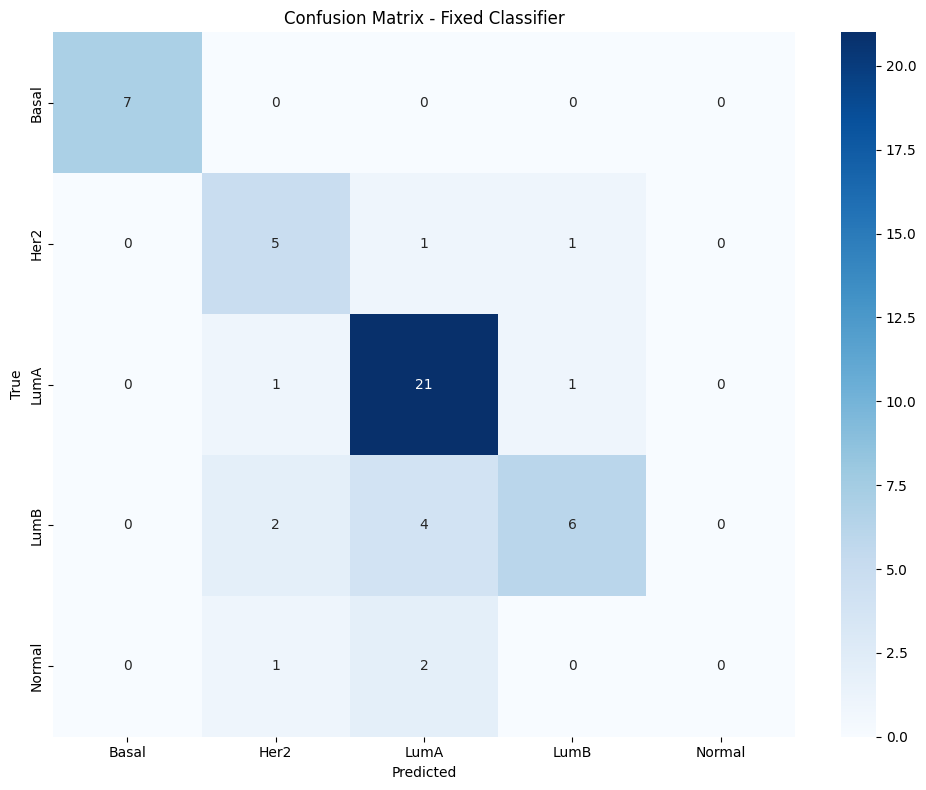

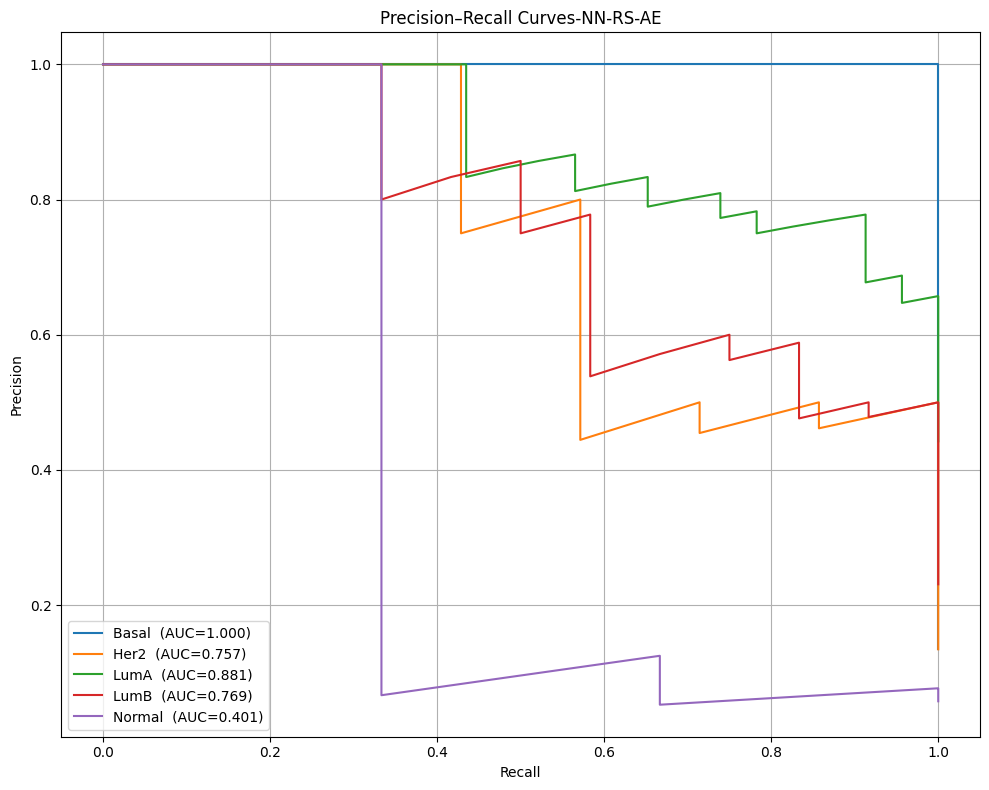


No training history found — skipping accuracy/loss plots.


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

# -------------------------------
# PREDICTIONS
# -------------------------------
y_pred_classes = best_model.predict(X_test_encoded)
y_pred_classes = le.transform(y_pred_classes)

# -------------------------------
# CLASSIFICATION REPORT
# -------------------------------
print("\nClassification Report (Fixed Classifier):")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

# -------------------------------
# CONFUSION MATRIX
# -------------------------------
cm = confusion_matrix(y_test_enc, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fixed Classifier')
plt.tight_layout()
plt.show()

# -------------------------------
# PRECISION–RECALL CURVES
# -------------------------------

# Predict probabilities for PR curve
y_pred_proba = best_model.predict_proba(X_test_encoded)

# Binarize labels for one-vs-rest PR curves
y_test_binarized = label_binarize(y_test_enc, classes=range(len(le.classes_)))

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(le.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f"{class_name}  (AUC={auc_score:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves-NN-RS-AE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# TRAINING HISTORY PLOTS (if available)
# -------------------------------
if 'history' in globals():
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

else:
    print("\nNo training history found — skipping accuracy/loss plots.")


In [4]:


# If you used a Scikeras wrapper
print("\nBest Keras model parameters:")
print(best_model.get_params())


Best Keras model parameters:
{'model': <function create_classifier at 0x0000026814B8F600>, 'build_fn': None, 'warm_start': False, 'random_state': 0, 'optimizer': 'rmsprop', 'loss': None, 'metrics': None, 'batch_size': 32, 'validation_batch_size': None, 'verbose': 0, 'callbacks': None, 'validation_split': 0.0, 'shuffle': True, 'run_eagerly': False, 'epochs': 100, 'class_weight': None, 'model__regularization': 'l1_l2', 'model__learning_rate': 0.0001, 'model__hidden_dim': 200, 'model__dropout_rate2': 0.4, 'model__dropout_rate1': 0.3, 'model__activation': 'tanh'}


In [76]:
import shap
import lime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, ReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# ==========================================
# SETTINGS
# ==========================================
original_feature_names = X_train.columns.tolist()

MAX_BACKGROUND = 30
MAX_EXPLAIN = 30
SHAP_BATCH_SIZE = 10
RANDOM_STATE = 42
TOP_K = 10

OUT_DIR = "./explain_results"
os.makedirs(OUT_DIR, exist_ok=True)

# ==========================================
# BUILD AUTOENCODER (EXPLICIT DECODER)
# ==========================================
def build_autoencoder2(input_dim, encoding_dim=500, hidden_dim1=5000, hidden_dim2=2000,
                      l2_reg=1e-14, learning_rate=3e-5):
    # Encoder
    inp = Input(shape=(input_dim,))
    x = Dense(hidden_dim1, kernel_regularizer=regularizers.l2(l2_reg))(inp)
    x = ReLU()(x)
    x = Dense(hidden_dim2, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = ReLU()(x)
    encoded = Dense(encoding_dim, kernel_regularizer=regularizers.l2(l2_reg))(x)
    encoded_act = ReLU()(encoded)

    # Decoder
    x = Dense(hidden_dim2, kernel_regularizer=regularizers.l2(l2_reg))(encoded_act)
    x = ReLU()(x)
    x = Dense(hidden_dim1, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = ReLU()(x)
    decoded = Dense(input_dim, activation='linear')(x)

    autoencoder2 = Model(inp, decoded)
    encoder2 = Model(inp, encoded_act)

    # Explicit decoder model
    encoded_input = Input(shape=(encoding_dim,))
    d = autoencoder2.layers[-6](encoded_input)  # first decoder Dense
    d = autoencoder2.layers[-5](d)             # first ReLU
    d = autoencoder2.layers[-4](d)             # second decoder Dense
    d = autoencoder2.layers[-3](d)             # second ReLU
    d = autoencoder2.layers[-2](d)             # output Dense
    decoder2 = Model(encoded_input, d)

    autoencoder2.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return autoencoder2, encoder2, decoder2

# Assume input_dim is known
autoencoder2, encoder2, decoder2 = build_autoencoder2(input_dim)

# ==========================================
# MODEL EXTRACTION
# ==========================================
print("\n[MODEL] Extracting best Keras model...")
keras_model = None
try:
    keras_model = getattr(best_model, "model_", None)
    if keras_model is None:
        keras_model = best_model.named_steps.get("nn").model_
except Exception:
    keras_model = best_model  # fallback

if keras_model is None:
    raise ValueError("Could not extract Keras model from best_model!")

print("Using Keras model:", type(keras_model))
print(f"Model input shape: {keras_model.input_shape}")

# ==========================================
# USE ENCODED DATA FOR SHAP
# ==========================================
if isinstance(X_train_encoded, pd.DataFrame):
    X_train_arr = X_train_encoded.values
    X_test_arr = X_test_encoded.values
else:
    X_train_arr = X_train_encoded
    X_test_arr = X_test_encoded

feature_names_encoded = [f"Encoded_{i}" for i in range(X_train_arr.shape[1])]
print(f"Using {len(feature_names_encoded)} encoded features")

# ==========================================
# SHAP EXPLANATIONS
# ==========================================
def shap_sample_fallback(X, n, random_state):
    if hasattr(shap, "sample"):
        return shap.sample(X, n, random_state=random_state)
    else:
        idx = np.random.RandomState(random_state).choice(len(X), size=n, replace=False)
        return X[idx]

small_bg = shap_sample_fallback(X_train_arr, min(MAX_BACKGROUND, len(X_train_arr)), RANDOM_STATE)
small_test = shap_sample_fallback(X_test_arr, min(MAX_EXPLAIN, len(X_test_arr)), RANDOM_STATE)

try:
    print("Attempting DeepExplainer...")
    explainer = shap.DeepExplainer(keras_model, small_bg)
    shap_values = explainer.shap_values(small_test, check_additivity=False)
    expected_value = explainer.expected_value
    use_deep = True
except Exception as e:
    print(f"DeepExplainer failed: {e}")
    print("→ Using KernelExplainer with batch processing...")
    def model_wrapper(X):
        return keras_model.predict(X, batch_size=32, verbose=0)
    explainer = shap.KernelExplainer(model_wrapper, small_bg)
    shap_values_list = []
    total_batches = int(np.ceil(len(small_test) / SHAP_BATCH_SIZE))
    for i in range(0, len(small_test), SHAP_BATCH_SIZE):
        batch_end = min(i + SHAP_BATCH_SIZE, len(small_test))
        batch = small_test[i:batch_end]
        batch_shap = explainer.shap_values(batch)
        shap_values_list.append(batch_shap)
        gc.collect()
    if isinstance(shap_values_list[0], list):
        n_classes = len(shap_values_list[0])
        shap_values = [np.vstack([b[c] for b in shap_values_list]) for c in range(n_classes)]
    else:
        shap_values = np.vstack(shap_values_list)
    expected_value = explainer.expected_value
    use_deep = False

del explainer
gc.collect()

if isinstance(shap_values, list):
    shap_values = np.stack([np.array(s) for s in shap_values], axis=2)

# ==========================================
# OVERALL SHAP IMPORTANCE
# ==========================================
if shap_values.ndim == 3:
    shap_values_overall = np.abs(shap_values).max(axis=2)
else:
    shap_values_overall = np.abs(shap_values)

mean_abs_shap_overall = shap_values_overall.mean(axis=0)
shap_importances_overall = pd.DataFrame({
    "Feature": feature_names_encoded,
    "MeanAbsSHAP_MaxAcrossClasses": mean_abs_shap_overall
}).sort_values(by="MeanAbsSHAP_MaxAcrossClasses", ascending=False)

top_features_overall = shap_importances_overall.head(TOP_K)
top_features_overall.to_csv(os.path.join(OUT_DIR, "top_features_overall_max.csv"), index=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=top_features_overall,
            x="MeanAbsSHAP_MaxAcrossClasses",
            y="Feature",
            palette="Greens_d")
plt.title("Top 10 SHAP Encoded Features (Overall)")
plt.xlabel("Mean |SHAP| Value")
plt.ylabel("Encoded Feature")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "top10_overall_bar.png"), dpi=150)
plt.close()

print("\n=== Top 10 Encoded Features (Overall) ===")
print(top_features_overall)

# ==========================================
# DECODE SHAP VALUES TO ORIGINAL SPACE
# ==========================================
def decode_shap_values(shap_values_encoded, autoencoder, encoding_dim, original_dim):
    """
    Approximate decoding of SHAP values from encoded space to original feature space.
    Uses decoder weights to map SHAP values back.
    
    Parameters:
        shap_values_encoded: np.array, SHAP values in encoded space
        autoencoder: trained Keras autoencoder
        encoding_dim: int, size of encoded vector
        original_dim: int, number of original features
    """
    # Build decoder input
    from tensorflow.keras.layers import Input
    from tensorflow.keras.models import Model

    encoded_input = Input(shape=(encoding_dim,))
    
    # Manually get decoder layers (assume your autoencoder is structured like yours)
    # Here we use all layers after the encoded layer
    decoder_layers = autoencoder.layers[-6:]  # adjust according to your autoencoder
    
    x = encoded_input
    for layer in decoder_layers:
        x = layer(x)
    decoder_model = Model(encoded_input, x)

    # Propagate SHAP values through decoder using weights
    decoded_shap = shap_values_encoded.copy()
    for layer in decoder_layers:
        if hasattr(layer, "get_weights") and len(layer.get_weights()) > 0:
            W, b = layer.get_weights()
            decoded_shap = np.dot(decoded_shap, W)
            # Apply ReLU if exists
            if hasattr(layer, "activation") and layer.activation.__name__ == "relu":
                decoded_shap = np.maximum(decoded_shap, 0)
    
    # Truncate/pad to match original feature size
    decoded_shap = decoded_shap[:, :original_dim]
    return decoded_shap


encoding_dim = 500  # match your autoencoder's encoding_dim
original_dim = X_train.shape[1]

decoded_shap_full = decode_shap_values(shap_values_overall, autoencoder, encoding_dim, original_dim)
decoded_importance = np.mean(np.abs(decoded_shap_full), axis=0)

decoded_df = pd.DataFrame({
    "Feature": original_feature_names,  # your original feature names
    "ApproxMeanAbsSHAP": decoded_importance
}).sort_values(by="ApproxMeanAbsSHAP", ascending=False)


decoded_df.to_csv(os.path.join(OUT_DIR, "decoded_shap_features.csv"), index=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=decoded_df.head(TOP_K),
    x="ApproxMeanAbsSHAP",
    y="Feature",
    palette="Blues_d"
)
plt.title("Top 10 Original Features (Decoded SHAP Approximation)")
plt.xlabel("Approx. Mean |SHAP| Value")
plt.ylabel("Original Feature")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "top10_decoded_bar.png"), dpi=150)
plt.close()

# ==========================================
# EXTRACT CLASS LABELS
# ==========================================
try:
    # Try to get class names from the model or label encoder
    if hasattr(best_model, 'classes_'):
        class_names = best_model.classes_.tolist()
    elif hasattr(best_model, 'named_steps') and 'nn' in best_model.named_steps:
        if hasattr(best_model.named_steps['nn'], 'classes_'):
            class_names = best_model.named_steps['nn'].classes_.tolist()
        else:
            class_names = None
    else:
        class_names = None
    
    # Fallback to y_train unique values if available
    if class_names is None and 'y_train' in globals():
        class_names = sorted(y_train.unique().tolist())
    
    print(f"[SHAP] Detected class names: {class_names}")
except Exception as e:
    print(f"[SHAP] Could not extract class names: {e}")
    class_names = None

# ==========================================
# SHAP SUMMARY PLOTS FOR EACH CLASS
# ==========================================
if shap_values.ndim == 3:
    n_classes = shap_values.shape[2]
    print(f"\n[SHAP] Creating summary plots for {n_classes} classes...")
    
    for class_idx in range(n_classes):
        class_label = class_names[class_idx] if class_names else f"Class {class_idx}"
    for class_idx in range(n_classes):
        class_label = class_names[class_idx] if class_names else f"Class {class_idx}"
        class_shap = shap_values[:, :, class_idx]
        
        # Summary plot (beeswarm)
        plt.figure(figsize=(12, 10))
        shap.summary_plot(
            class_shap,
            small_test,
            feature_names=feature_names_encoded,
            max_display=TOP_K,
            show=False
        )
        plt.title(f"SHAP Summary Plot - {class_label}", fontsize=14, pad=20)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"shap_summary_{class_label.lower().replace(' ', '_')}.png"), dpi=150, bbox_inches='tight')
        plt.close()
        
        # Bar plot (mean absolute SHAP)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            class_shap,
            small_test,
            feature_names=feature_names_encoded,
            max_display=TOP_K,
            plot_type="bar",
            show=False
        )
        plt.title(f"SHAP Feature Importance - {class_label}", fontsize=14, pad=20)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"shap_bar_{class_label.lower().replace(' ', '_')}.png"), dpi=150, bbox_inches='tight')
        plt.close()
        
        # Save class-specific importance
        mean_abs_shap_class = np.abs(class_shap).mean(axis=0)
        class_importance = pd.DataFrame({
            "Feature": feature_names_encoded,
            "MeanAbsSHAP": mean_abs_shap_class
        }).sort_values(by="MeanAbsSHAP", ascending=False)
        class_importance.to_csv(os.path.join(OUT_DIR, f"top_features_{class_label.lower().replace(' ', '_')}.csv"), index=False)
        
        print(f"  ✓ {class_label} summary plots saved")
    
    print(f"\n✓ Summary plots for all {n_classes} classes completed")
else:
    # Binary classification or regression
    print("\n[SHAP] Creating summary plot (single output)...")
    
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        shap_values,
        small_test,
        feature_names=feature_names_encoded,
        max_display=TOP_K,
        show=False
    )
    plt.title("SHAP Summary Plot", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "shap_summary.png"), dpi=150, bbox_inches='tight')
    plt.close()
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values,
        small_test,
        feature_names=feature_names_encoded,
        max_display=TOP_K,
        plot_type="bar",
        show=False
    )
    plt.title("SHAP Feature Importance", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "shap_bar.png"), dpi=150, bbox_inches='tight')
    plt.close()
    
    print("  ✓ Summary plots saved")

print("\n✅ SHAP analysis complete and decoded to original feature space.")
print(f"Results saved to: {OUT_DIR}")
print("Note: Decoded SHAP values are approximate due to nonlinear decoder layers.")


[MODEL] Extracting best Keras model...
Using Keras model: <class 'keras.src.models.functional.Functional'>
Model input shape: (None, 500)
Using 500 encoded features
Attempting DeepExplainer...


C:\Users\mike\AppData\Local\Temp\ipykernel_62944\3010044367.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features_overall,



=== Top 10 Encoded Features (Overall) ===
         Feature  MeanAbsSHAP_MaxAcrossClasses
462  Encoded_462                      0.048424
444  Encoded_444                      0.038202
41    Encoded_41                      0.033768
405  Encoded_405                      0.033186
91    Encoded_91                      0.033160
24    Encoded_24                      0.029281
276  Encoded_276                      0.029060
251  Encoded_251                      0.029030
158  Encoded_158                      0.028864
482  Encoded_482                      0.028769


MemoryError: Unable to allocate 368. MiB for an array with shape (5000, 19277) and data type float32